In [96]:
class CONFIG:
    len_period = 28
    num_periods = 5
    window = 411
    path = '/kaggle/input/sber-dataset/data.csv'
    num_trials_optuna = 1000
    use_optuna_tuning = False
    len_predict = 365

In [97]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from lightgbm import LGBMRegressor

import optuna

In [98]:
df = pd.read_csv(CONFIG.path, sep=';')
def resample_date(x):
    list_ = x.split('.')
    return '-'.join([list_[2]]+[list_[1]]+[list_[0]])


In [99]:
df['REPORTDATE'] =  pd.to_datetime(df['REPORTDATE'].transform(resample_date))
df.index = df['REPORTDATE']

In [100]:
def show_time_series(data, show=True, label='Временной ряд', second_=False):
    if not second_:
        plt.figure(figsize=(16, 8))
    plt.plot( data.index, data.values, label=label)
    
    if show:
        plt.legend()
        plt.show()

In [101]:
train_ts, test_ts = train_test_split(df, test_size=0.2, shuffle=False)

In [102]:
train_ts

,REPORTDATE,VALUE
REPORTDATE,,
2013-12-30,2013-12-30,3457625638
2013-12-31,2013-12-31,3417092149
2014-01-01,2014-01-01,3417092149
2014-01-02,2014-01-02,3417092149
2014-01-03,2014-01-03,3417092149
...,...,...
2018-08-09,2018-08-09,58999288196
2018-08-10,2018-08-10,57402158309
2018-08-11,2018-08-11,57402158309


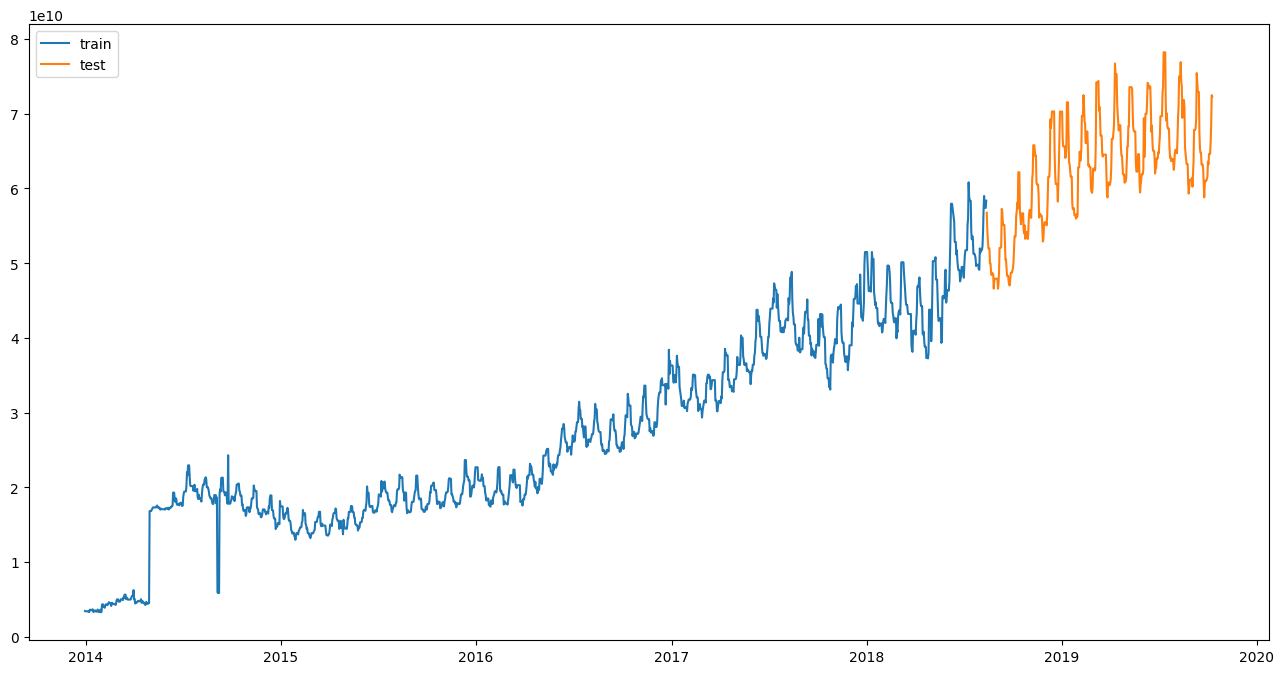

In [103]:
#show_time_series(df['VALUE'], show=False, label='train')
show_time_series(train_ts['VALUE'], show=False, label='train')
show_time_series(test_ts['VALUE'], label='test', second_=True)

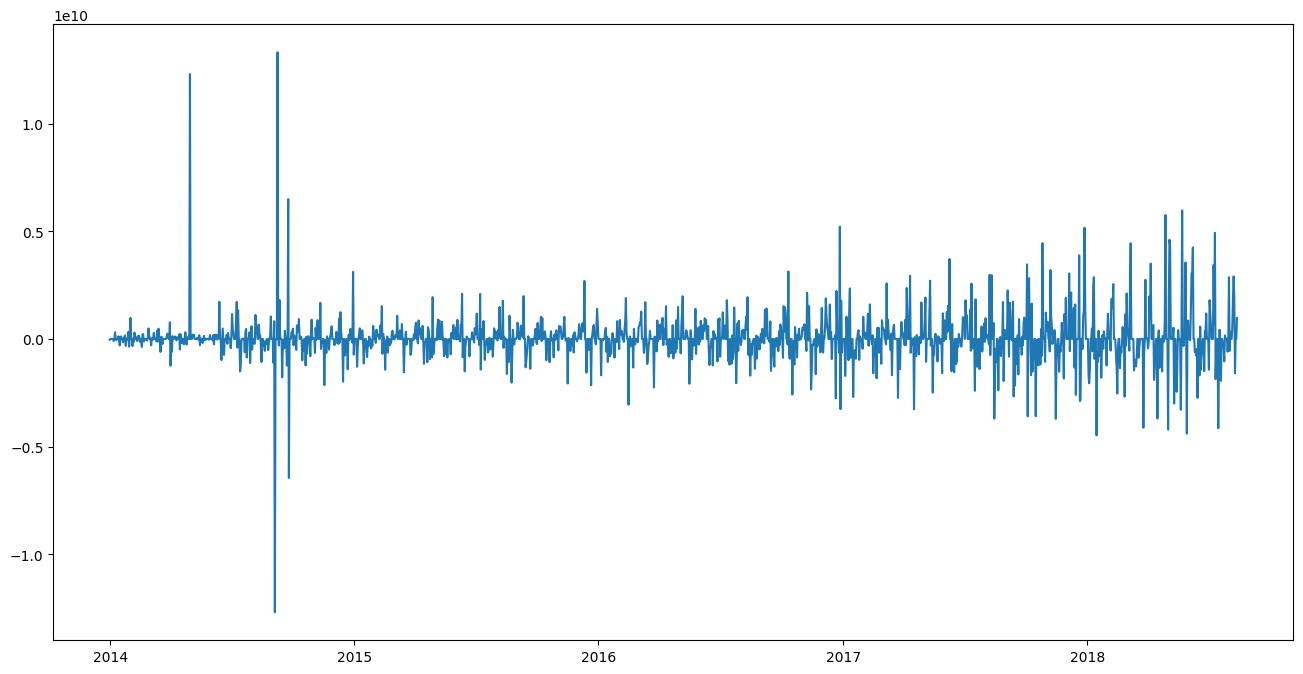

In [104]:
#работает только с train_ts
show_time_series(train_ts.diff(1)['VALUE'], show=False, label='train')

In [105]:
# Проведем тест Дики-Фулера на проверку стационарности ряда
_, p, _, _, _, _= adfuller(train_ts.diff(1)['VALUE'].fillna(0))
p < 0.5 # ряд стационаорен

True

In [106]:
train_diff = train_ts.diff(1)['VALUE'].fillna(0)

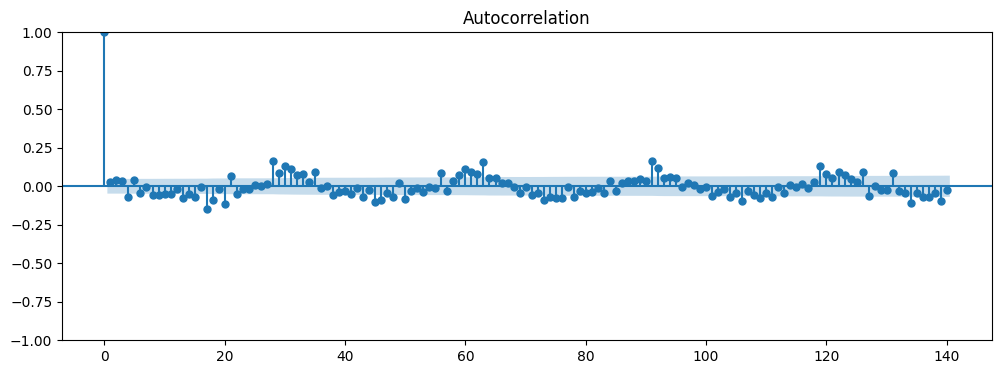

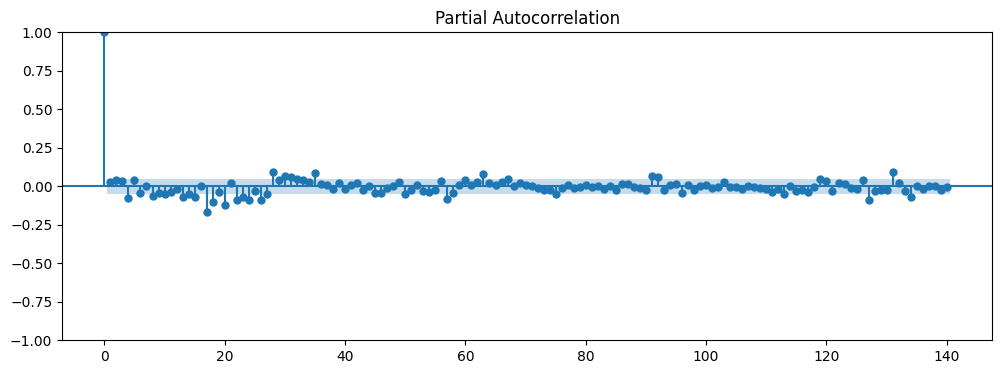

In [107]:
#acf, pacf

fig, axe = plt.subplots(figsize=(12, 4))
plot_acf(train_diff, lags=CONFIG.len_period*5, ax=axe)
plt.show()

fig, axe = plt.subplots(figsize=(12, 4))
plot_pacf(train_diff, lags=CONFIG.len_period*5, ax=axe)
plt.show()

In [108]:

p=42
q=45
P=8
Q=7
s = CONFIG.len_period

In [109]:
#Построим модель SARIMA самостоятельно, а потом с помощью statsmodel

$x_t = c + \phi_1 x_{t-1} + \theta_1 \varepsilon_{t-1} + \cdots + \phi_p x_{t-p} + \theta_q \varepsilon_{t-q} + \varepsilon_t - \alpha_1 \varepsilon_{t-1} - \cdots - \alpha_P \varepsilon_{t-P} - \beta_1 (x_{t-m} - x_{t-2m}) - \cdots - \beta_Q (x_{t-Qm} - x_{t-(Q+1)m}) $

$ y_t = \alpha x_{t-5} + \beta \frac{x_{t-5} + x_{t-10}}{2} + \gamma x_{t-1} + \theta \frac{x_{t-1} + x_{t-6}}{2} + \varepsilon_t $

$ y_t = c + \phi_1 x_{t-1} + \theta_1 \varepsilon_{t-1} + \alpha_1 \varepsilon_{t-5} + \alpha_2 \varepsilon_{t-10} + \beta_1 \varepsilon_{t-1} + \beta_2 \varepsilon_{t-6} + \varepsilon_t $

In [110]:
sarima_df = pd.DataFrame(index = train_ts.index, columns=[f'x_t-{i}' for i in range(1, p+1)]+\
                         ['ma']+[f'X_t-{i}' for i in range(1, P+1)]+[ 'MA'])
sarima_df.head(2)

,x_t-1,x_t-2,x_t-3,x_t-4,x_t-5,x_t-6,x_t-7,x_t-8,x_t-9,x_t-10,...,ma,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,MA
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
weights_q = [0.8*(0.2**i) for i in range(q)]
weights_Q = [0.8*(0.2**i) for i in range(Q)]
for i in range(1, p+1):
    sarima_df[f'x_t-{i}'] = train_diff.shift(i).fillna(0)
for i in range(1, P+1):
    sarima_df[f'X_t-{i}'] = train_diff.shift(i*s).fillna(0)

ma_i = []
for i in range(1, q+1):
    sarima_df[f'ma_{i}'] = train_diff.shift(i).fillna(0)
    ma_i.append(f'ma_{i}')
    
sarima_df['ma'] = np.average(sarima_df[ma_i], weights=weights_q, axis=1)
sarima_df.drop(columns=ma_i, inplace=True)

MA_i = []
for i in range(1, Q+1):
    sarima_df[f'MA_{i}'] = train_diff.shift(i*s).fillna(0)
    MA_i.append(f'MA_{i}')
    
sarima_df['MA'] = np.average(sarima_df[MA_i], weights=weights_Q, axis=1)
sarima_df.drop(columns=MA_i, inplace=True)

In [112]:
sarima_df

,x_t-1,x_t-2,x_t-3,x_t-4,x_t-5,x_t-6,x_t-7,x_t-8,x_t-9,x_t-10,...,ma,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,MA
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2013-12-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-01,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.242679e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-02,0.000000e+00,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-6.485358e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-03,0.000000e+00,0.000000e+00,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.297072e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.000000e+00,3.330160e+08,-554786968.0,2.867135e+09,-8.578486e+07,-5.916362e+08,...,2.644812e+09,-1.864960e+09,-4.621210e+08,4.101282e+08,-1.345111e+09,0.000000e+00,-2.151751e+08,-457630147.0,5.163223e+09,-1.561490e+09
2018-08-10,1.886860e+09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.000000e+00,333016036.0,-5.547870e+08,2.867135e+09,-8.578486e+07,...,2.038450e+09,-6.123239e+08,-2.737478e+09,-5.364590e+07,-6.752204e+08,0.000000e+00,5.540152e+08,347204818.0,1.633842e+09,-9.337460e+08
2018-08-11,-1.597130e+09,1.886860e+09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.0,3.330160e+08,-5.547870e+08,2.867135e+09,...,-8.700138e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00


In [113]:
model = Lasso(alpha=0)
model.fit(sarima_df, train_diff)
pred_lasso = model.predict(sarima_df)

In [114]:
sarima_df

,x_t-1,x_t-2,x_t-3,x_t-4,x_t-5,x_t-6,x_t-7,x_t-8,x_t-9,x_t-10,...,ma,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,MA
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2013-12-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-01,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.242679e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-02,0.000000e+00,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-6.485358e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-03,0.000000e+00,0.000000e+00,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.297072e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.000000e+00,3.330160e+08,-554786968.0,2.867135e+09,-8.578486e+07,-5.916362e+08,...,2.644812e+09,-1.864960e+09,-4.621210e+08,4.101282e+08,-1.345111e+09,0.000000e+00,-2.151751e+08,-457630147.0,5.163223e+09,-1.561490e+09
2018-08-10,1.886860e+09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.000000e+00,333016036.0,-5.547870e+08,2.867135e+09,-8.578486e+07,...,2.038450e+09,-6.123239e+08,-2.737478e+09,-5.364590e+07,-6.752204e+08,0.000000e+00,5.540152e+08,347204818.0,1.633842e+09,-9.337460e+08
2018-08-11,-1.597130e+09,1.886860e+09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.0,3.330160e+08,-5.547870e+08,2.867135e+09,...,-8.700138e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00


In [115]:
pred_lasso = pd.DataFrame(pred_lasso, index=train_diff.index)

In [116]:
mape(train_ts['VALUE'], train_ts['VALUE'].shift(1, fill_value=train_ts['VALUE'].iloc[0])+pred_lasso.squeeze(1))

0.023920158058546758

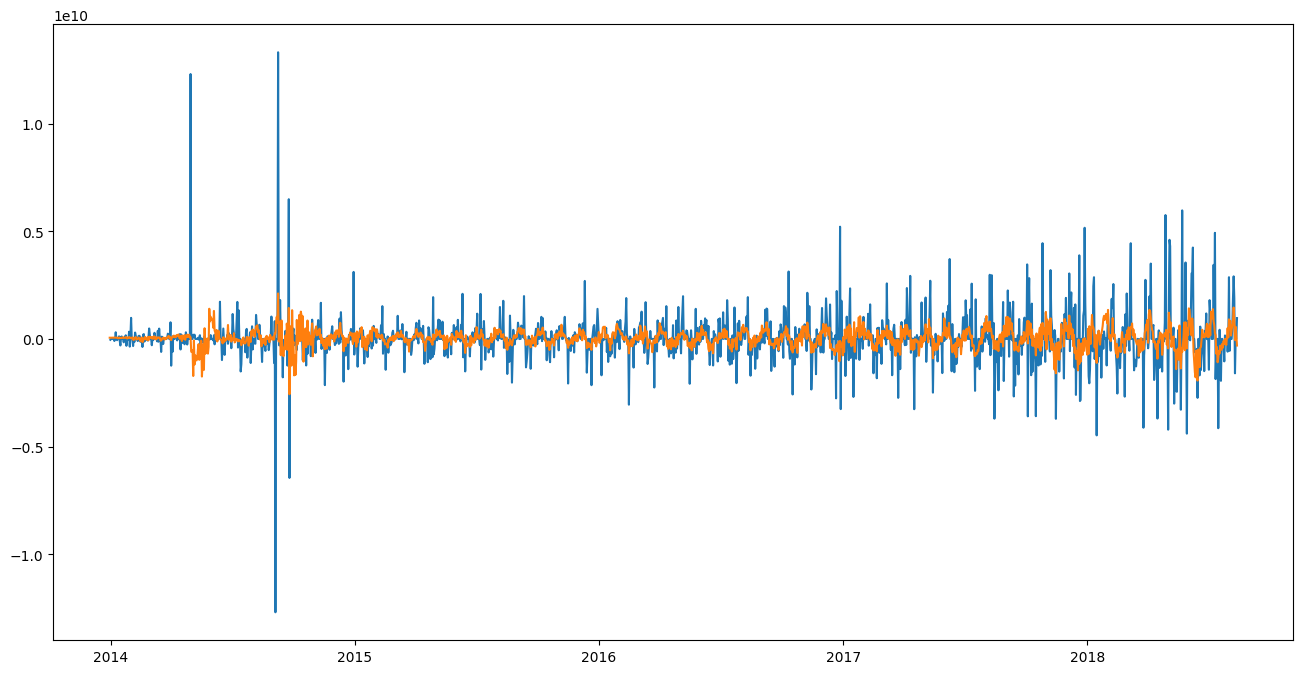

In [117]:
show_time_series(train_ts.diff(1)['VALUE'], show=False, label='train')
show_time_series(pred_lasso, show=False, label='pred', second_=True)

In [118]:
#show_time_series(train_ts.diff(1)['VALUE'], show=False, label='train')
#show_time_series(pred_gbm, show=False, label='pred', second_=True)

In [119]:
model.coef_

array([ 0.04872163, -0.03357016, -0.03964073, -0.13501179, -0.01867869,
       -0.0878364 , -0.06499094, -0.07833453, -0.09276073, -0.06718794,
       -0.04711031, -0.02238628, -0.07675794, -0.0660273 , -0.04772492,
       -0.00543035, -0.14351132, -0.09145561, -0.02302655, -0.11193512,
        0.03541149, -0.05876927, -0.05492212, -0.05263732, -0.00398301,
       -0.06183   , -0.02832282,  0.10858964,  0.06140793,  0.08141026,
        0.07770193,  0.06273251,  0.0599914 ,  0.03618553,  0.0941831 ,
        0.02615429,  0.01360422, -0.00866165,  0.02668659, -0.01856651,
        0.01170632,  0.02011403, -0.11513372,  0.00329718,  0.04290093,
        0.0018063 , -0.013622  , -0.00370584,  0.01171453, -0.01396927,
        0.03248123, -0.00564707])

In [120]:
sarima_df

,x_t-1,x_t-2,x_t-3,x_t-4,x_t-5,x_t-6,x_t-7,x_t-8,x_t-9,x_t-10,...,ma,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,MA
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2013-12-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-01,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.242679e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-02,0.000000e+00,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-6.485358e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2014-01-03,0.000000e+00,0.000000e+00,-4.053349e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.297072e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.000000e+00,3.330160e+08,-554786968.0,2.867135e+09,-8.578486e+07,-5.916362e+08,...,2.644812e+09,-1.864960e+09,-4.621210e+08,4.101282e+08,-1.345111e+09,0.000000e+00,-2.151751e+08,-457630147.0,5.163223e+09,-1.561490e+09
2018-08-10,1.886860e+09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.000000e+00,333016036.0,-5.547870e+08,2.867135e+09,-8.578486e+07,...,2.038450e+09,-6.123239e+08,-2.737478e+09,-5.364590e+07,-6.752204e+08,0.000000e+00,5.540152e+08,347204818.0,1.633842e+09,-9.337460e+08
2018-08-11,-1.597130e+09,1.886860e+09,2.906465e+09,1.885622e+09,5.579533e+08,0.000000e+00,0.0,3.330160e+08,-5.547870e+08,2.867135e+09,...,-8.700138e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00


In [121]:
#mape(train_ts['VALUE'], train_ts['VALUE'].shift(1, fill_value=train_ts['VALUE'].iloc[0])+pred_gbm.squeeze(1))

In [122]:
#Предсказание на тесте

In [123]:
ts = train_ts['VALUE'].diff(1).values
ts_not_diff = train_ts['VALUE'].values


In [124]:
def objective(trial):
    
   # data, test_x, target, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    #print(len(data), len(test_x))
    param = {
        'metric': 'rmse', 
        'n_estimators': trial.suggest_categorical('n_estimators', [1000+i*100 for i in range(100)]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1),
        'subsample': 1,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 5, log=True),
        'num_leaves' : trial.suggest_int('num_leaves', 4, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
    }
    p = trial.suggest_int('p', 2, 50)
    q = trial.suggest_int('q', 5, 50)
    P = trial.suggest_int('P', 1, 12)
    Q = trial.suggest_int('Q', 1,10)
    sarima_df = pd.DataFrame(index = train_ts.index, columns=[f'x_t-{i}' for i in range(1, p+1)]+\
                         ['ma']+[f'X_t-{i}' for i in range(1, P+1)]+[ 'MA'])
    weights_q = [0.8*(0.2**i) for i in range(q)]
    weights_Q = [0.8*(0.2**i) for i in range(Q)]
    for i in range(1, p+1):
        sarima_df[f'x_t-{i}'] = train_diff.shift(i).fillna(0)
    for i in range(1, P+1):
        sarima_df[f'X_t-{i}'] = train_diff.shift(i*s).fillna(0)

    ma_i = []
    for i in range(1, q+1):
        sarima_df[f'ma_{i}'] = train_diff.shift(i).fillna(0)
        ma_i.append(f'ma_{i}')

    sarima_df['ma'] = np.average(sarima_df[ma_i], weights=weights_q, axis=1)
    sarima_df.drop(columns=ma_i, inplace=True)

    MA_i = []
    for i in range(1, Q+1):
        sarima_df[f'MA_{i}'] = train_diff.shift(i*s).fillna(0)
        MA_i.append(f'MA_{i}')

    sarima_df['MA'] = np.average(sarima_df[MA_i], weights=weights_Q, axis=1)
    sarima_df.drop(columns=MA_i, inplace=True)
    ts = train_ts['VALUE'].diff(1).values
    ts_not_diff = train_ts['VALUE'].values
    lgbm = LGBMRegressor(**param)
    lgbm.fit(sarima_df, train_diff)

    for i in range(len(test_ts)):
        time_feats = [ts[-j] for j in range(1, p+1)] + [np.average(ts[-1:-q-1:-1], weights=weights_q, axis=0)] +\
        [ts[-s*k] for k in range(1, P+1)] +\
        [np.average([ts[-s*k] for k in range(1, Q+1)], weights = weights_Q, axis=0)]
        time_feats = np.array(time_feats).reshape( 1, -1)
        ts = np.append(ts, lgbm.predict(time_feats))
        ts_not_diff = np.append(ts_not_diff, ts[-1]+ts_not_diff[-1])
    pred_test = pd.DataFrame(ts_not_diff, index=df.index)
    show_time_series(df['VALUE'], show=False, label='train')
    show_time_series(pred_test, label=trial, second_=True)
    errors = mse(test_ts['VALUE'], ts_not_diff[-len(test_ts):], squared=False)
    return errors

In [125]:
if CONFIG.use_optuna_tuning:
    study = optuna.create_study(direction='minimize', study_name='Optimize boosting hyperparameters')
    study.optimize(objective, n_trials=CONFIG.num_trials_optuna)

In [126]:
ts = train_ts['VALUE'].diff(1).values
ts_not_diff = train_ts['VALUE'].values


In [127]:
best_params = {'n_estimators': 4600, 'reg_alpha': 0.0020144258078378927, 'reg_lambda': 0.0020504610264148646, 
               
               'colsample_bytree': 0.9738706070459671, 'learning_rate': 0.005751295579717974, 
               'num_leaves': 74, 'min_child_samples': 88}
if CONFIG.use_optuna_tuning:
    best_params = study.best_params
lgbm = LGBMRegressor(**best_params)
lgbm.fit(sarima_df, train_diff)
pred_gbm = lgbm.predict(sarima_df)
pred_gbm = pd.DataFrame(pred_gbm, index=train_diff.index)

In [128]:
for i in range(len(test_ts)):
    time_feats = [ts[-j] for j in range(1, p+1)] + [np.average(ts[-1:-q-1:-1], weights=weights_q, axis=0)] +\
    [ts[-s*k] for k in range(1, P+1)] +\
    [np.average([ts[-s*k] for k in range(1, Q+1)], weights = weights_Q, axis=0)]
    time_feats = np.array(time_feats).reshape( 1, -1)
    ts = np.append(ts, lgbm.predict(time_feats))
    ts_not_diff = np.append(ts_not_diff, ts[-1]+ts_not_diff[-1])

In [129]:
pred_test = pd.DataFrame(ts_not_diff, index=df.index)

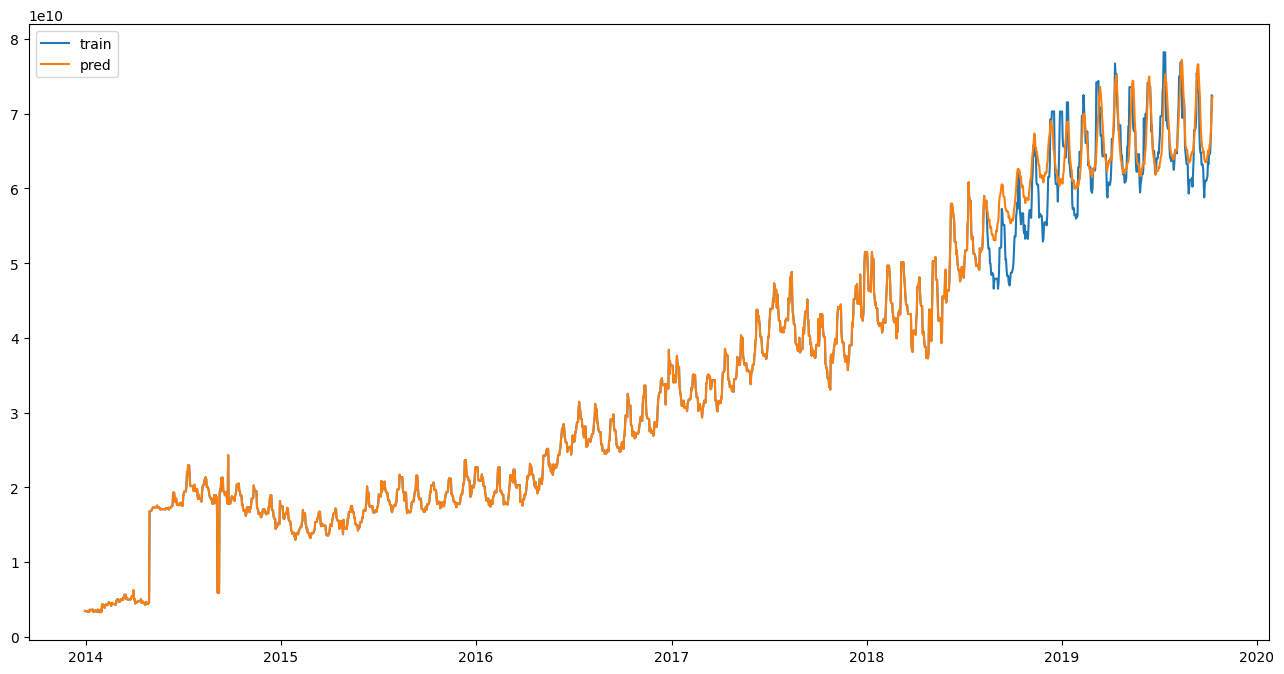

In [130]:
show_time_series(df['VALUE'], show=False, label='train')
show_time_series(pred_test, label='pred', second_=True)

In [131]:
mape(test_ts['VALUE'], ts_not_diff[-len(test_ts):])

0.05308520183182185

In [132]:
df_diff = df.diff(1)['VALUE'].fillna(0)

In [133]:
final_df = pd.DataFrame(index = df.index, columns=[f'x_t-{i}' for i in range(1, p+1)]+\
                         ['ma']+[f'X_t-{i}' for i in range(1, P+1)]+[ 'MA'])
weights_q = [0.8*(0.2**i) for i in range(q)]
weights_Q = [0.8*(0.2**i) for i in range(Q)]
for i in range(1, p+1):
    final_df[f'x_t-{i}'] = df_diff.shift(i).fillna(0)
for i in range(1, P+1):
    final_df[f'X_t-{i}'] = df_diff.shift(i*s).fillna(0)

ma_i = []
for i in range(1, q+1):
    final_df[f'ma_{i}'] = df_diff.shift(i).fillna(0)
    ma_i.append(f'ma_{i}')
    
final_df['ma'] = np.average(final_df[ma_i], weights=weights_q, axis=1)
final_df.drop(columns=ma_i, inplace=True)

MA_i = []
for i in range(1, Q+1):
    final_df[f'MA_{i}'] = df_diff.shift(i*s).fillna(0)
    MA_i.append(f'MA_{i}')
    
final_df['MA'] = np.average(final_df[MA_i], weights=weights_Q, axis=1)
final_df.drop(columns=MA_i, inplace=True)

In [134]:
ts = df['VALUE'].diff(1).values
ts_not_diff = df['VALUE'].values

In [135]:
for i in range(CONFIG.len_predict):
    time_feats = [ts[-j] for j in range(1, p+1)] + [np.average(ts[-1:-q-1:-1], weights=weights_q, axis=0)] +\
    [ts[-s*k] for k in range(1, P+1)] +\
    [np.average([ts[-s*k] for k in range(1, Q+1)], weights = weights_Q, axis=0)]
    time_feats = np.array(time_feats).reshape( 1, -1)
    ts = np.append(ts, lgbm.predict(time_feats))
    ts_not_diff = np.append(ts_not_diff, ts[-1]+ts_not_diff[-1])

In [139]:
pred_test = pd.DataFrame(ts_not_diff, index=list(df.index)+[df.index[-1]+timedelta(days=i) for i in range(1, CONFIG.len_predict+1)])

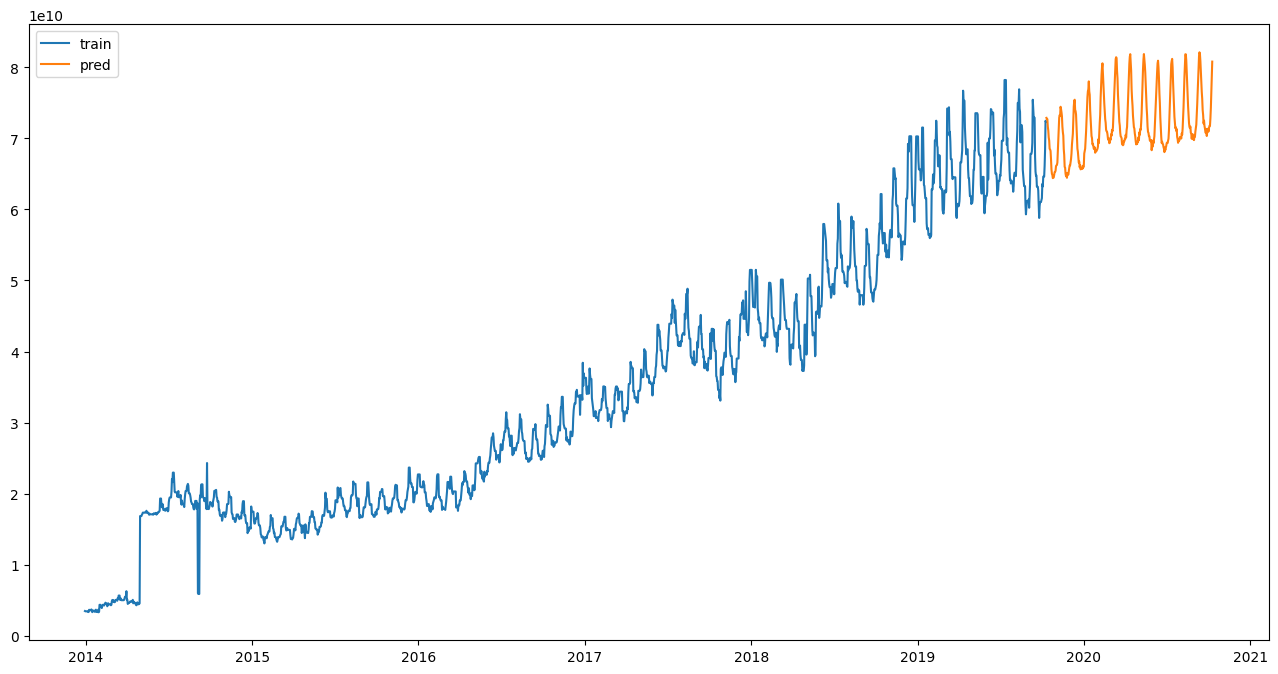

In [141]:
show_time_series(df['VALUE'], show=False, label='train')
show_time_series(pred_test.iloc[-CONFIG.len_predict:], label='pred', second_=True)